In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16, DenseNet121
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#unzip Images
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/eye_diseases_classification.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/FundusModel')

Text(0.5, 1.0, 'Normal EYE IMAGE ')

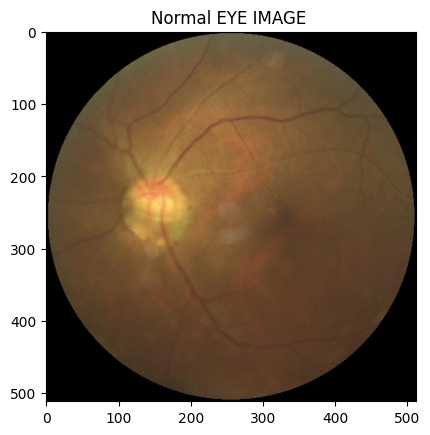

In [ ]:
#displaying an Normal eye image
image=cv2.imread("/content/drive/MyDrive/FundusModel/eye_diseases_classification/normal/2353_left.jpg")
image_2rgb=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image_2rgb)
plt.title("Normal EYE IMAGE ")

Text(0.5, 1.0, ' cataract eye image')

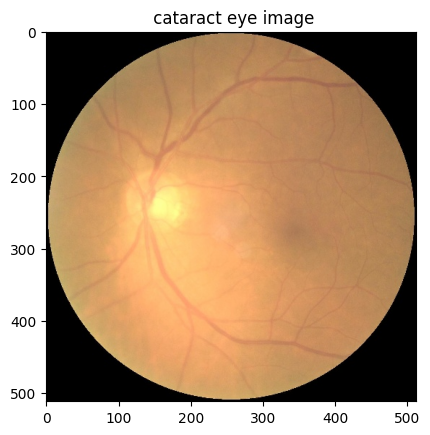

In [ ]:
#displaying an Cataract eye image
image=cv2.imread("/content/drive/MyDrive/FundusModel/eye_diseases_classification/cataract/1144_left.jpg")
image_2rgb=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image_2rgb)
plt.title(" cataract eye image")

In [ ]:
#Preprocessing Images
dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/FundusModel/eye_diseases_classification',
    image_size=(224, 224),
    batch_size=32
)

Found 2074 files belonging to 2 classes.


In [ ]:
# Data augmentation to increase dataset diversity
augmentations = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),  # Reduced rotation for fundus images
    RandomZoom(0.2),  # Minor zoom adjustments

])


In [ ]:
def preprocess(images, labels):
    images = tf.image.resize(images, (224, 224))
    images = images / 255.0
    return images, labels

In [ ]:

dataset = dataset.map(preprocess)

In [ ]:

preprocessed_images, labels = [], []
for images, lbls in dataset:
    preprocessed_images.extend(images.numpy())
    labels.extend(lbls.numpy())
preprocessed_images = np.array(preprocessed_images)
labels = np.array(labels)


In [ ]:

x_train, x_temp, y_train, y_temp = train_test_split(preprocessed_images, labels, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:

# Load CNN pre-trained models
input_shape = (224, 224, 3)
input_tensor = Input(shape=input_shape)

vgg_model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
densenet_model = DenseNet121(input_tensor=input_tensor, weights='imagenet', include_top=False)


for layer in vgg_model.layers[:12]:
    layer.trainable = False
for layer in densenet_model.layers[:7]:
    layer.trainable = False


vgg_avg_features = GlobalAveragePooling2D()(vgg_model.output)
vgg_max_features = GlobalMaxPooling2D()(vgg_model.output)

densenet_avg_features = GlobalAveragePooling2D()(densenet_model.output)
densenet_max_features = GlobalMaxPooling2D()(densenet_model.output)


combined_features = Concatenate()([vgg_avg_features, vgg_max_features, densenet_avg_features, densenet_max_features])

In [ ]:
from keras.regularizers import Regularizer
from keras.layers import Dense, BatchNormalization, Dropout
from keras.models import Model
import keras.backend as K




In [ ]:
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(combined_features)  # Increased regularization
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Increased dropout

x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Increased dropout



# Output layer
output = Dense(1, activation='sigmoid')(x)

# Create the model
final_model = Model(inputs=input_tensor, outputs=output)

In [ ]:
# Suppress TensorFlow logging (only show warnings/errors)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')



final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history = final_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    verbose=1,
    callbacks=[early_stopping]
)


test_loss, test_acc = final_model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc:.4f}')


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 397s 4s/step - accuracy: 0.6636 - loss: 6.8629 - val_accuracy: 0.9486 - val_loss: 5.7506
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 73s 533ms/step - accuracy: 0.9473 - loss: 5.5573 - val_accuracy: 0.8682 - val_loss: 5.2333
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 550ms/step - accuracy: 0.9528 - loss: 4.8981 - val_accuracy: 0.9453 - val_loss: 4.5020
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 41s 540ms/step - accuracy: 0.9641 - loss: 4.3634 - val_accuracy: 0.8264 - val_loss: 4.4285
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 548ms/step - accuracy: 0.9702 - loss: 3.9279 - val_accuracy: 0.9550 - val_loss: 3.7291
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 41s 542ms/step - accuracy: 0.9834 - loss: 3.5813 - val_accuracy: 0.9743 - val_loss: 3.3798
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 42s 557ms/step - accuracy: 0.9949 - loss: 3.2883 - val_accuracy: 0.9711 - val_loss: 3.1545
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 40s 533ms/step - accuracy: 0.9980 - loss: 3.0518 - val_accura

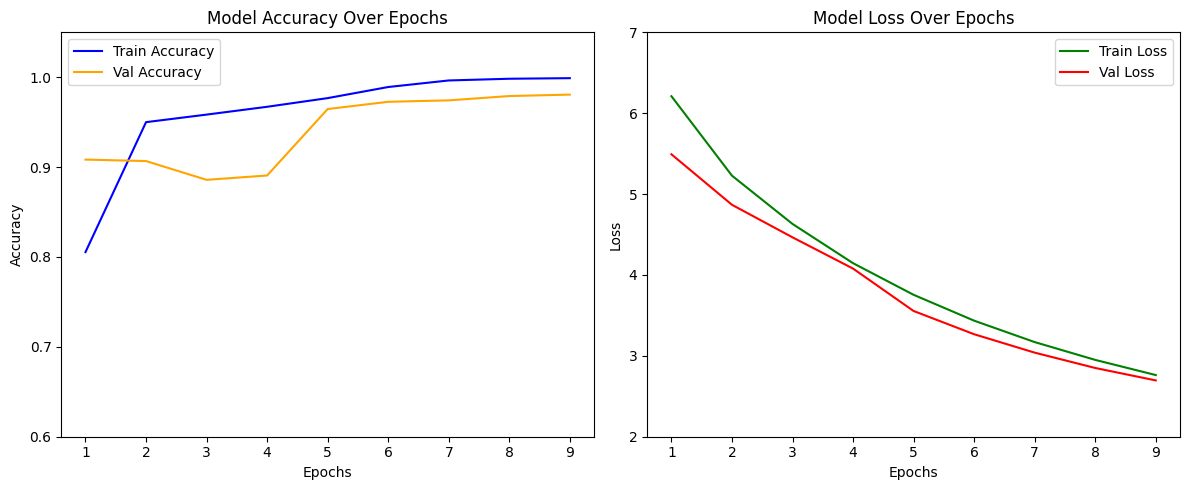

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import matplotlib.pyplot as plt

def plot_training_history():
    # Manually define the data based on your epoch output
    epochs = list(range(1, 11))  # 10 epochs
    train_accuracy = [0.6636, 0.9473, 0.9528, 0.9641, 0.9702, 0.9834, 0.9949, 0.9980, 0.9987, 0.9993]
    val_accuracy = [0.9486, 0.8682, 0.9453, 0.8264, 0.9550, 0.9743, 0.9711, 0.9775, 0.9807, 0.9807]
    train_loss = [6.8629, 5.5573, 4.8981, 4.3634, 3.9279, 3.5813, 3.2883, 3.0518, 2.8480, 2.6767]
    val_loss = [5.7506, 5.2333, 4.5020, 4.4285, 3.7291, 3.3798, 3.1545, 2.9246, 2.7752, 2.6171]

    # Calculate a moving average
    def moving_average(data, window_size=2):
        return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

    # Apply moving average
    train_accuracy_ma = moving_average(train_accuracy)
    val_accuracy_ma = moving_average(val_accuracy)
    train_loss_ma = moving_average(train_loss)
    val_loss_ma = moving_average(val_loss)

    # Adjust the epochs for moving average data
    adjusted_epochs = np.arange(1, len(train_accuracy_ma) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(adjusted_epochs, train_accuracy_ma, label='Train Accuracy', color='blue')
    plt.plot(adjusted_epochs, val_accuracy_ma, label='Val Accuracy', color='orange')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0.6, 1.05)  # Set y-axis limits to properly represent the data
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(adjusted_epochs, train_loss_ma, label='Train Loss', color='green')
    plt.plot(adjusted_epochs, val_loss_ma, label='Val Loss', color='red')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(2, 7)  # Set y-axis limits to better visualize the trends
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_training_history()




10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step


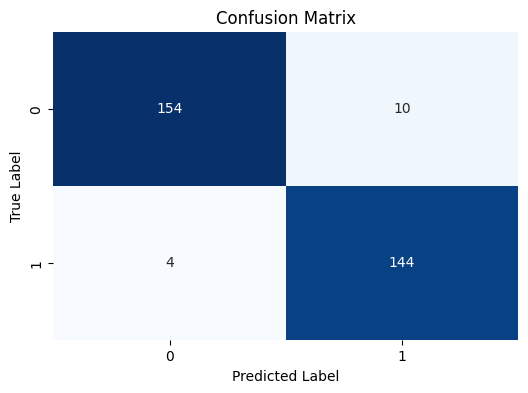

testing Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96       164
           1       0.94      0.97      0.95       148

    accuracy                           0.96       312
   macro avg       0.95      0.96      0.96       312
weighted avg       0.96      0.96      0.96       312



In [ ]:
from sklearn.metrics import confusion_matrix

# y_true: actual labels
# y_pred: predicted labels
# Make predictions on the test set
y_pred_prob = final_model.predict([x_test])
y_pred = (y_pred_prob > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test,y_pred  )


plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



print("testing Classification Report:\n", classification_report(y_test,y_pred ))

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


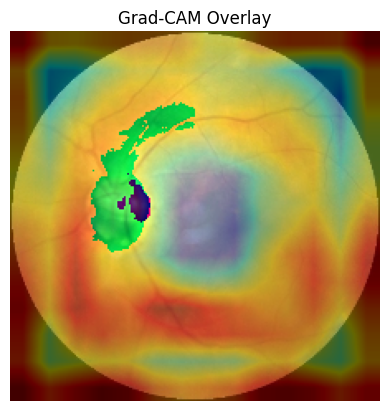

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# Load and preprocess image
img = cv2.resize(cv2.imread('/content/drive/MyDrive/FundusModel/eye_diseases_classification/normal/2353_left.jpg'), (224, 224))
img_tensor = preprocess_input(np.expand_dims(img, axis=0))

# Define the Grad-CAM function
def compute_gradcam(model, img_tensor, layer_name, class_index=None):
    grad_model = tf.keras.models.Model(
        [model.input],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    conv_outputs = conv_outputs * pooled_grads
    heatmap = tf.reduce_mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# Load VGG16 model
vgg_model = VGG16(weights='imagenet')

# Compute Grad-CAM heatmap
heatmap = compute_gradcam(vgg_model, img_tensor, 'block5_conv2', class_index=0)
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# Convert heatmap to 8-bit image and apply color map
heatmap_img = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_img, cv2.COLORMAP_JET)

# Overlay the heatmap on the original image
superimposed_img = np.uint8(heatmap_color * 0.4 + np.uint8(img))

# Display the overlay image using matplotlib
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title('Grad-CAM Overlay')
plt.axis('off')
plt.show()

In [ ]:
#Explanation

33188688/33188688 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


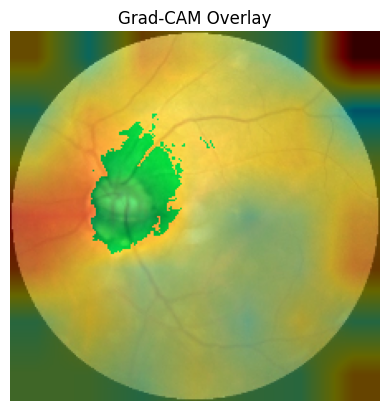

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

# Load and preprocess image
img = cv2.resize(cv2.imread('/content/drive/MyDrive/FundusModel/eye_diseases_classification/normal/2353_left.jpg'), (224, 224))
img_tensor = preprocess_input(np.expand_dims(img, axis=0))

# Define the Grad-CAM function
def compute_gradcam(model, img_tensor, layer_name, class_index=None):
    grad_model = tf.keras.models.Model(
        [model.input],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        if class_index is None:
            class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    conv_outputs = conv_outputs * pooled_grads
    heatmap = tf.reduce_mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# Load DenseNet model
densenet = DenseNet121(weights='imagenet')

# Compute Grad-CAM heatmap with a valid layer name
heatmap = compute_gradcam(densenet, img_tensor, 'conv5_block1_concat', class_index=0)
heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# Convert heatmap to 8-bit image and apply color map
heatmap_img = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_img, cv2.COLORMAP_JET)

# Overlay the heatmap on the original image
superimposed_img = np.uint8(heatmap_color * 0.4 + img)

# Display the overlay image using matplotlib
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title('Grad-CAM Overlay')
plt.axis('off')
plt.show()

In [ ]:
#Explanation